In [9]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS , summarize)
import matplotlib.pyplot as plt

In [10]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA , QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [11]:
Smarket = load_data('Smarket')
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [12]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [13]:
Smarket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Year       1250 non-null   int64   
 1   Lag1       1250 non-null   float64 
 2   Lag2       1250 non-null   float64 
 3   Lag3       1250 non-null   float64 
 4   Lag4       1250 non-null   float64 
 5   Lag5       1250 non-null   float64 
 6   Volume     1250 non-null   float64 
 7   Today      1250 non-null   float64 
 8   Direction  1250 non-null   category
dtypes: category(1), float64(7), int64(1)
memory usage: 79.6 KB


In [14]:
numeric_columns = [col for col in Smarket.columns if col != 'Direction']
Smarket_numeric = Smarket[numeric_columns]
Smarket_numeric.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


As one would expect, the correlations between the lagged return variables and today's return are close to zero. The only substantial correlation is between `Year` and `Volume`. By plotting the data, we see that `Volume` is increasing over time. In other words, the average number of shares traded daily increased from 2001 to 2005.

<Axes: >

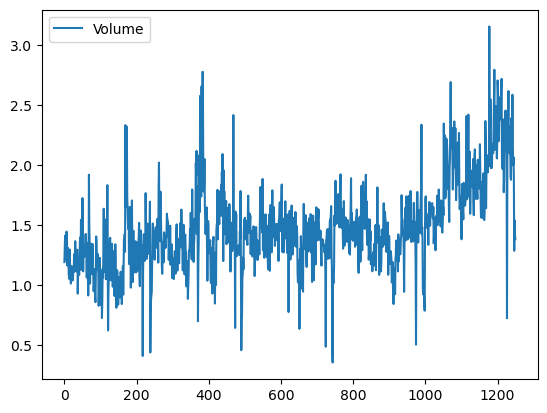

In [15]:
Smarket.plot(y='Volume')

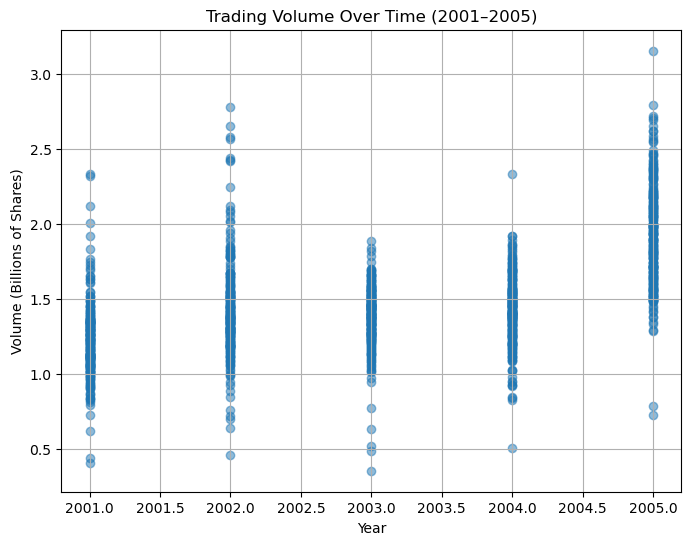

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(Smarket['Year'], Smarket['Volume'], alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Volume (Billions of Shares)')
plt.title('Trading Volume Over Time (2001–2005)')
plt.grid(True)
plt.show()

### 4.7.2 Logistic Regression

In [17]:
allvars = Smarket.columns.drop (['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
glm = sm.GLM(y,X,family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


The coefficients indicate the change in the log-odds of `Direction = "Up"` for a one-unit increase in each predictor, holding others constant.

For example, a coefficient of `-0.073` for `Lag1` means that a 1% increase in the previous day’s return (`Lag1`) slightly decreases the log-odds of the market going up.

The high p-values (e.g., > 0.05 for all predictors) suggest that none of the predictors are statistically significant at the 5% level, indicating weak predictive power for `Direction`.

In [18]:
probs = results.predict ()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [19]:
labels = np.array (['Down']*1250)
labels[probs >0.5] = "Up"
labels

array(['Up', 'Down', 'Down', ..., 'Up', 'Up', 'Up'], dtype='<U4')

In [20]:
confusion_table(labels , Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


The diagonal elements of the confusion matrix indicate correct predictions, while the off-diagonals represent incorrect predictions. Hence, our model correctly predicted that the market would go up on 507 days and that it would go down on 145 days, for a total of `507 + 145 = 652` correct predictions. The `np.mean()` function can be used to compute the fraction of days for which the prediction was correct. In this case, logistic regression correctly predicted the movement of the market 52.2% of the time.

In [21]:
(507+145) /1250 , np.mean(labels == Smarket.Direction)

(0.5216, 0.5216)

At first glance, it appears that the logistic regression model is working a little better than random guessing. However, this result is misleading because we trained and tested the model on the same set of 1,250 observations. In other words, `100 − 52.2 = 47.8%` is the **training error rate**. As we have seen previously, the training error rate is often overly optimistic — it tends to underestimate the test error rate. In order to better assess the accuracy of the logistic regression model in this setting, we can fit the model using part of the data, and then examine how well it predicts the held-out data. This will yield a more realistic error rate, in the sense that in practice we will be interested in our model’s performance not on the data that we used to fit the model, but rather on days in the future for which the market’s movements are unknown.

To implement this strategy, we first create a Boolean vector corresponding to the observations from 2001 through 2004. We then use this vector to create a held-out data set of observations from 2005.

In [22]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

In [23]:
X_train , X_test = X.loc[train], X.loc[~train]
y_train , y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train , X_train , family=sm.families.Binomial ())
results = glm_train.fit()
probs = results.predict(exog=X_test)
probs[:10]

998     0.528220
999     0.515669
1000    0.522652
1001    0.513854
1002    0.498334
1003    0.501091
1004    0.502770
1005    0.509568
1006    0.504011
1007    0.510641
dtype: float64

Notice that we have trained and tested our model on two completely separate data sets: training was performed using only the dates before 2005, and testing was performed using only the dates in 2005. Finally, we compare the predictions for 2005 to the actual movements of the market over that time period. We will first store the test and training labels (recall `y_test` is binary).

In [24]:
D = Smarket.Direction
L_train , L_test = D.loc[train], D.loc[~train]

In [25]:
labels = np.array (['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels , L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [26]:
np.mean(labels == L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

Accuracy `48%`, Error rate `52%`

We recall that the logistic regression model had very underwhelming p-values associated with all of the predictors, and that the smallest p-value, though not very small, corresponded to `Lag1`. Perhaps by removing the variables that appear not to be helpful in predicting `Direction`, we can obtain a more effective model.

In [27]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)

X = model.transform(Smarket)
X_train , X_test = X.loc[train], X.loc[~train]

glm_train = sm.GLM(y_train , X_train , family=sm.families.Binomial ())
results = glm_train.fit()

probs = results.predict(exog=X_test)

labels = np.array (['Down']*252)
labels[probs >0.5] = 'Up'
confusion_table(labels , L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [28]:
np.mean(labels == L_test), np.mean(labels != L_test)

(0.5595238095238095, 0.44047619047619047)

Suppose that we want to predict the returns associated with particular values of `Lag1` and `Lag2`. In particular, we want to predict `Direction` on a day when `Lag1` and `Lag2` equal 1.2 and 1.1, respectively, and on a day when they equal 1.5 and −0.8.

In [29]:
newdata = pd.DataFrame ({'Lag1':[1.2 , 1.5], 'Lag2':[1.1 , -0.8]});
newX = model.transform(newdata)
probs = results.predict(newX)
probs

0    0.479146
1    0.496094
dtype: float64

In [30]:
labels = np.array (['Down']*2)
labels[probs >0.5] = 'Up'
labels

array(['Down', 'Down'], dtype='<U4')

### 4.7.3 Linear Discriminant Analysis

In [31]:
lda = LDA( store_covariance=True)

# Since the LDA estimator automatically adds an intercept, we should re-
# move the column corresponding to the intercept in both X_train and X_test.
# We can also directly use the labels rather than the Boolean vectors y_train.

X_train , X_test = [M.drop(columns =['intercept']) for M in [X_train , X_test ]]
lda.fit(X_train , L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [32]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

First row (`[0.04279022, 0.03389409]`): Means for `Down` class.

Second row (`[-0.03954635, -0.03132544]`): Means for `Up` class.

**Interpretation**:
- **Row 1 (Down)**: For days when `Direction = Down` in the training set:
  - Mean of `Lag1`: `0.04279022` (previous day’s return was +0.043% on average).
  - Mean of `Lag2`: `0.03389409` (two days prior return was +0.034% on average).
- **Row 2 (Up)**: For days when `Direction = Up` in the training set:
  - Mean of `Lag1`: `-0.03954635` (previous day’s return was -0.040% on average).
  - Mean of `Lag2`: `-0.03132544` (two days prior return was -0.031% on average).

In [33]:
lda.priors_

# lda.priors_ represents the estimated prior probabilities of the classes (Down and Up) in the training data (L_train).



array([0.49198397, 0.50801603])

In [34]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [35]:
lda.scalings_
# lda.scalings_ represents the coefficients of the linear discriminant function(s) used by LDA to separate the classes (Down and Up).



array([[-0.64201904],
       [-0.51352928]])

In [41]:
lda_pred = lda.predict(X_test)

In [37]:
confusion_table(lda_pred , L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [38]:
lda_prob = lda.predict_proba(X_test)
np.all(np.where(lda_prob [:,1] >= 0.5, 'Up','Down') == lda_pred)

True

### 4.7.4 Quadratic Discriminant Analysis

In [42]:
qda = QDA( store_covariance=True)
qda.fit(X_train , L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [43]:
qda.means_ , qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [44]:
qda.covariance_ [0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

the covariance matrix for a class describes how the features vary and co-vary within that class. Unlike Linear Discriminant Analysis (LDA), which assumes all classes share the same covariance matrix, QDA allows each class to have its own covariance matrix, making it more flexible for cases where classes have different spreads or correlations.



In [45]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred , L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [56]:
np.mean(qda_pred == L_test)

0.5992063492063492

Interestingly, the QDA predictions are accurate almost 60% of the time

### 4.7.5 Naive Bayes

In [47]:
NB = GaussianNB ()
NB.fit(X_train , L_train)

GaussianNB()

In [48]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [98]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [97]:
# NB.theta_ is a NumPy array containing the mean of each feature for each class.
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [51]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [52]:
X_train[L_train == 'Down'].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

In [53]:
X_train[L_train == 'Down'].var(ddof =0)

Lag1    1.503554
Lag2    1.532467
dtype: float64

In [54]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels , L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [57]:
np.mean(nb_labels == L_test)

0.5952380952380952

Naive Bayes performs well on these data, with accurate predictions over
59% of the time. This is slightly worse than QDA, but much better than
LDA.

### 4.7.6 K-Nearest Neighbors

In [58]:
knn1 = KNeighborsClassifier(n_neighbors =1)
knn1.fit(X_train , L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred , L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [59]:
np.mean(knn1_pred == L_test)

0.5

The results using K = 1 are not very good, since only 50% of the observations are correctly predicted. Of course, it may be that K = 1 results in an overly-flexible fit to the data

In [61]:
# using K = 3.
knn3 = KNeighborsClassifier(n_neighbors =3)
knn3_pred = knn3.fit(X_train , L_train).predict(X_test)
np.mean(knn3_pred == L_test)

0.5317460317460317

The results have improved slightly. However, increasing `K` further provides no further improvements. It appears that for these data, and this train/test split, **QDA** gives the best results of the methods examined so far.

### 4.7.7 Linear and Poisson Regression on the Bikeshare Data

In [63]:
Bike = load_data('Bikeshare')
Bike.head()

,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,bikers
0,1,Jan,1,0,0,6,0,clear,0.24,0.2879,0.81,0.0,3,13,16
1,1,Jan,1,1,0,6,0,clear,0.22,0.2727,0.80,0.0,8,32,40
2,1,Jan,1,2,0,6,0,clear,0.22,0.2727,0.80,0.0,5,27,32
3,1,Jan,1,3,0,6,0,clear,0.24,0.2879,0.75,0.0,3,10,13
4,1,Jan,1,4,0,6,0,clear,0.24,0.2879,0.75,0.0,0,1,1


In [67]:
Bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8645 entries, 0 to 8644
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      8645 non-null   int64   
 1   mnth        8645 non-null   category
 2   day         8645 non-null   int64   
 3   hr          8645 non-null   category
 4   holiday     8645 non-null   int64   
 5   weekday     8645 non-null   int64   
 6   workingday  8645 non-null   int64   
 7   weathersit  8645 non-null   category
 8   temp        8645 non-null   float64 
 9   atemp       8645 non-null   float64 
 10  hum         8645 non-null   float64 
 11  windspeed   8645 non-null   float64 
 12  casual      8645 non-null   int64   
 13  registered  8645 non-null   int64   
 14  bikers      8645 non-null   int64   
dtypes: category(3), float64(4), int64(8)
memory usage: 836.6 KB


In [64]:
Bike.shape , Bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

#### Using One Hot Encoding

In [66]:
X = MS(['mnth',
'hr',
'workingday',
'temp',
'weathersit']).fit_transform(Bike)
Y = Bike['bikers']
M_lm = sm.OLS(Y, X).fit()
summarize(M_lm)

,coef,std err,t,P>|t|
intercept,-68.6317,5.307,-12.932,0.000
mnth[Feb],6.8452,4.287,1.597,0.110
mnth[March],16.5514,4.301,3.848,0.000
mnth[April],41.4249,4.972,8.331,0.000
mnth[May],72.5571,5.641,12.862,0.000
mnth[June],67.8187,6.544,10.364,0.000
mnth[July],45.3245,7.081,6.401,0.000
mnth[Aug],53.2430,6.640,8.019,0.000
mnth[Sept],66.6783,5.925,11.254,0.000
mnth[Oct],75.8343,4.950,15.319,0.000


The intercept represents the expected number of bike rentals when all predictors are at their reference levels (or zero for continuous variables).

Reference levels:
- `mnth`: January (since `mnth[Jan]` is dropped).
- `hr`: Hour 0 (midnight, since `hr[0]` is dropped).
- `weathersit`: Likely “clear” weather (reference level).
- `workingday`: 0 (non-working day).
- `temp`: 0 (very low temperature, since it’s normalized).

Interpretation: At midnight in `January`, on a non-working day with clear weather and very low temperature, the model predicts `-68.63` bike rentals. This negative value is unrealistic (bike rentals can’t be negative) and suggests that linear regression may not be ideal for count data, as it doesn’t enforce non-negativity.



#### Using Contrast Coding

In [92]:
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')
hr_encode

Column(idx='hr', name='hr', is_categorical=True, is_ordinal=False, columns=(), encoder=Contrast(method='sum'))

In [72]:
X2 = MS([ mnth_encode ,
hr_encode ,
'workingday',
'temp',
'weathersit']).fit_transform(Bike)
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
S2

,coef,std err,t,P>|t|
intercept,73.5974,5.132,14.340,0.000
mnth[Jan],-46.0871,4.085,-11.281,0.000
mnth[Feb],-39.2419,3.539,-11.088,0.000
mnth[March],-29.5357,3.155,-9.361,0.000
mnth[April],-4.6622,2.741,-1.701,0.089
mnth[May],26.4700,2.851,9.285,0.000
mnth[June],21.7317,3.465,6.272,0.000
mnth[July],-0.7626,3.908,-0.195,0.845
mnth[Aug],7.1560,3.535,2.024,0.043
mnth[Sept],20.5912,3.046,6.761,0.000


#### Key Points in the Output

Intercept (73.5974)
- Represents the average number of bike rentals when all predictors are at their mean effect levels, due to sum contrast coding.
- Unlike the previous model (where the intercept was -68.6317 for reference levels like January, hour 0, etc.), the intercept here is the grand mean of bike rentals, adjusted for the sum-to-zero constraints.
- The positive value (73.6) is more realistic for count data, though linear regression still allows negative predictions.

 `mnth[Jan]` to `mnth[Nov]`
- These coefficients represent the deviation of each month’s bike rentals from the overall mean (intercept).
- **Sum constraint**: The coefficient for `mnth[Dec]` (not included) is the negative sum of the listed coefficients:
  \[
  \text{mnth[Dec]} = -(\text{mnth[Jan]} + \text{mnth[Feb]} + \cdots + \text{mnth[Nov]})
  \]
- **Calculating**:
  \[
  \text{mnth[Dec]} = -(-46.0871 - 39.2419 - 29.5357 - 4.6622 + 26.4700 + 21.7317 - 0.7626 + 7.1560 + 20.5912 + 29.7472 + 14.2229) \approx 0.3705
  \]
- **Interpretation**:
  - `mnth[Jan] = -46.0871`: January has 46.1 fewer rentals than the average month, significant (p = 0.000).
  - `mnth[Oct] = 29.7472`: October has 29.7 more rentals than the average, significant (p = 0.000).
  - `mnth[July] = -0.7626`: July is close to the average (p = 0.845, not significant).
- **Trend**: Winter months (Jan–Mar) have negative coefficients (fewer rentals), while spring/fall (May, Oct) have positive coefficients (more rentals).

 `hr[0]` to `hr[22]`
- These coefficients represent the deviation of each hour’s rentals from the overall mean.
- **Sum constraint**: The coefficient for `hr[23]` is the negative sum of the listed coefficients.
- **Interpretation**:
  - `hr[0] = -96.1420`: Midnight has 96.1 fewer rentals than the average hour, significant (p = 0.000).
  - `hr[17] = 200.1249`: 5 PM has 200.1 more rentals than the average, significant (p = 0.000), likely due to evening commuting.
  - `hr[8] = 127.5199`: 8 AM (morning commute) has 127.5 more rentals than the average.
- **Trend**: Early morning hours (0–5) have large negative coefficients (low demand), while commuting hours (7–8, 16–18) have large positive coefficients (high demand).

 `workingday` (1.2696)
- Working days have 1.27 more rentals than non-working days, but the p-value (0.477) indicates this is not significant.

 `temp` (157.2094)
- For a 1-unit increase in normalized temperature, rentals increase by 157.2, highly significant (p = 0.000).
- This reflects higher bike usage in warmer weather.

 `weathersit`
- Coefficients are relative to the reference level (“clear” weather, dropped in dummy encoding).
- `weathersit[cloudy/misty] = -12.8903`: Cloudy/misty weather reduces rentals by 12.9 compared to clear, significant (p = 0.000).
- `weathersit[light rain/snow] = -66.4944`: Light rain/snow reduces rentals by 66.5, significant (p = 0.000).
- `weathersit[heavy rain/snow] = -109.7446`: Heavy rain/snow reduces rentals by 109.7, but not significant (p = 0.152), possibly due to few observations (large std err = 76.667).

In [94]:
# quantifies the total discrepancy.
np.sum(( M_lm.fittedvalues - M2_lm.fittedvalues)**2)

2.2400862816558918e-20

In [93]:
# confirms if the predictions are effectively the same within numerical precision.
np.allclose(M_lm.fittedvalues , M2_lm.fittedvalues)

True

In [76]:
coef_month = S2[S2.index.str.contains('mnth')]['coef']
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
Name: coef, dtype: float64

In [77]:
months = Bike['mnth']. dtype.categories
coef_month = pd.concat ([coef_month ,pd.Series ([- coef_month.sum()],index =['mnth[Dec]'])])
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
dtype: float64

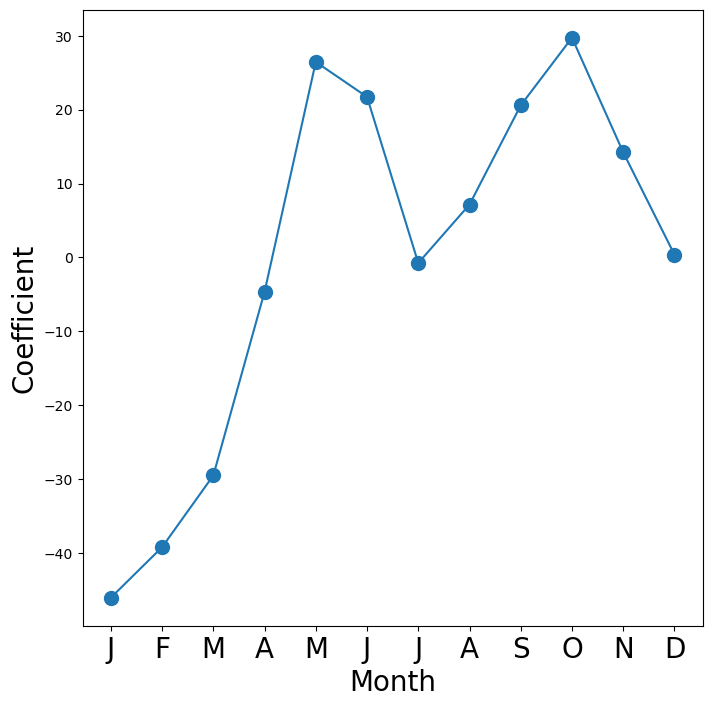

In [78]:
fig_month , ax_month = subplots(figsize =(8 ,8))
x_month = np.arange(coef_month.shape [0])
ax_month.plot(x_month , coef_month , marker='o', ms =10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels ([l[5] for l in coef_month.index], fontsize = 20)
ax_month.set_xlabel('Month', fontsize =20)
ax_month.set_ylabel('Coefficient', fontsize =20);

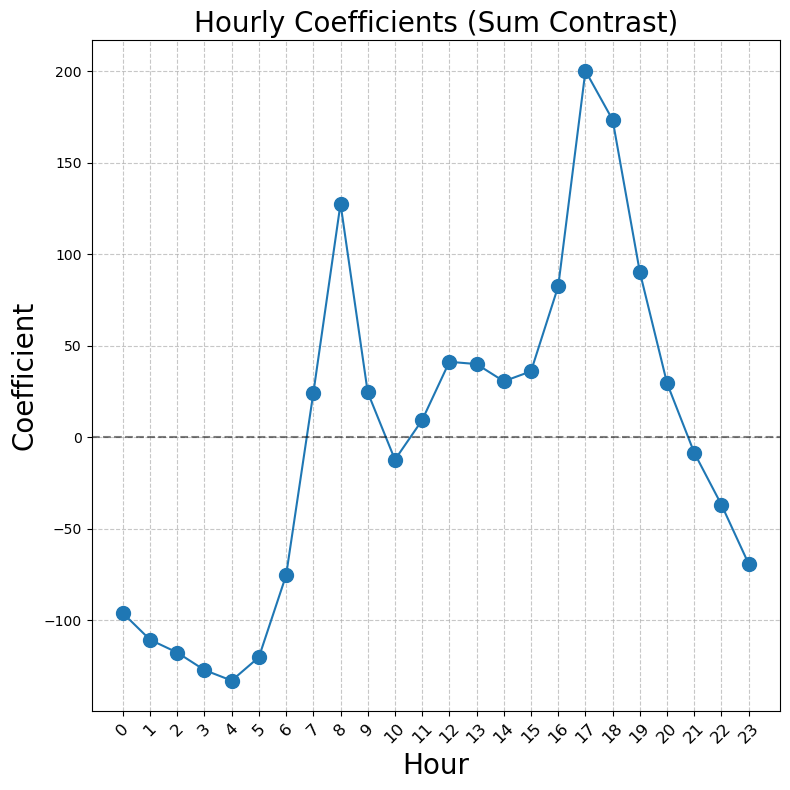

In [95]:
# Extract hr coefficients
coef_hr = S2[S2.index.str.contains('hr')]['coef']
if len(coef_hr) != 23:
    raise ValueError(f"Expected 23 hr coefficients, got {len(coef_hr)}")

# Reindex (optional, if order is not guaranteed)
coef_hr = coef_hr.reindex(['hr[{0}]'.format(h) for h in range(23)])

# Add hr[23] using sum-to-zero constraint
coef_hr = pd.concat([coef_hr, pd.Series([-coef_hr.sum()], index=['hr[23]'])])

# Verify no NaN values
if coef_hr.isna().any():
    raise ValueError("NaN values detected in coefficients")

# Create plot
fig_hr, ax_hr = subplots(figsize=(8, 8))
x_hr = np.arange(coef_hr.shape[0])
ax_hr.plot(x_hr, coef_hr, marker='o', ms=10, linestyle='-')
ax_hr.set_xticks(x_hr)  # All hours
ax_hr.set_xticklabels(range(24), fontsize=12, rotation=45)  # All hours, rotated
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20)
ax_hr.set_title('Hourly Coefficients (Sum Contrast)', fontsize=20)
ax_hr.axhline(0, color='black', linestyle='--', alpha=0.5)  # Zero line
ax_hr.grid(True, linestyle='--', alpha=0.7)  # Grid
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()



#### Poisson Regression

In [83]:
M_pois = sm.GLM(Y, X2 , family=sm.families.Poisson ()).fit()

In [85]:
S_pois = summarize(M_pois)
coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef']
coef_month = pd.concat ([ coef_month , pd.Series ([- coef_month.sum()], index =['mnth[Dec]'])])
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat ([ coef_hr ,
pd.Series ([- coef_hr.sum()],
index =['hr[23]'])])

/tmp/ipykernel_25559/4201880513.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_hr.set_xticklabels (range(24)[::2] , fontsize =20)


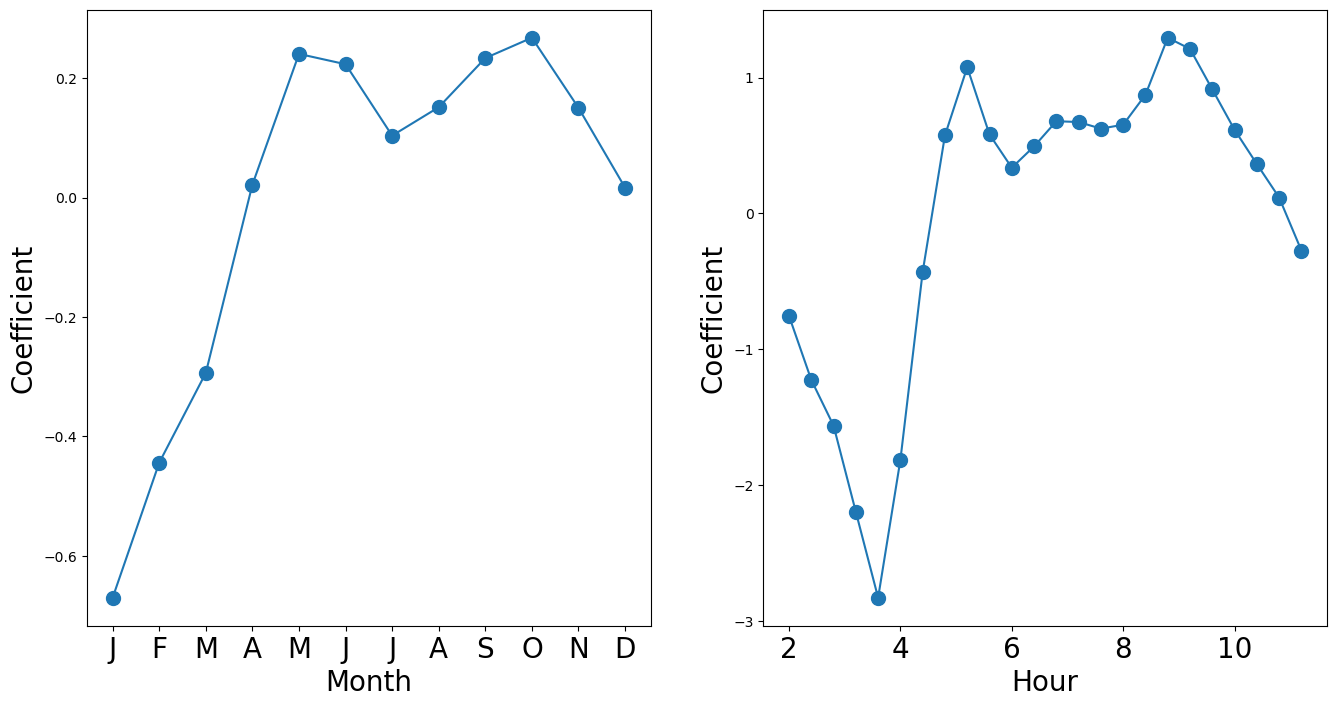

In [86]:
fig_pois , (ax_month , ax_hr) = subplots (1, 2, figsize =(16 ,8))
ax_month.plot(x_month , coef_month , marker='o', ms =10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels ([l[5] for l in coef_month.index], fontsize=20)
ax_month.set_xlabel('Month', fontsize =20)
ax_month.set_ylabel('Coefficient', fontsize =20)
ax_hr.plot(x_hr , coef_hr , marker='o', ms =10)
ax_hr.set_xticklabels (range(24)[::2] , fontsize =20)
ax_hr.set_xlabel('Hour', fontsize =20)
ax_hr.set_ylabel('Coefficient', fontsize =20);

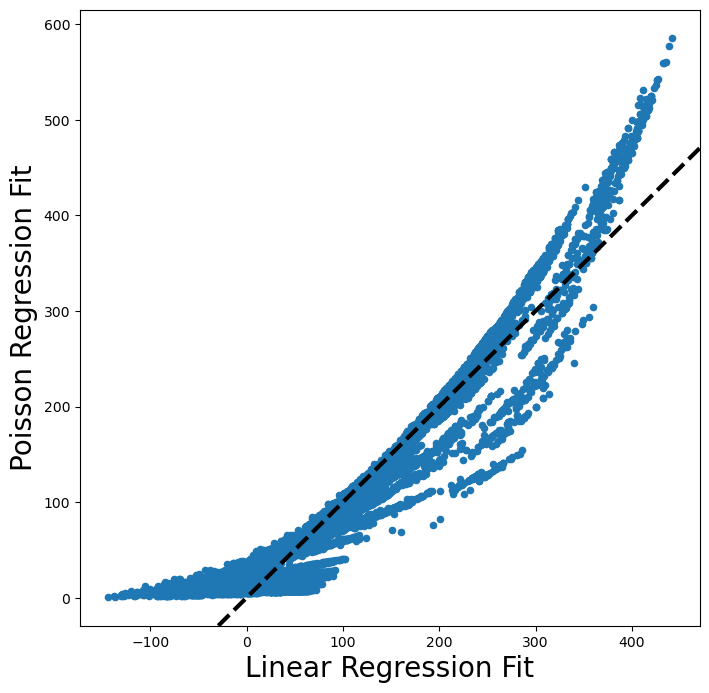

In [88]:
fig , ax = subplots(figsize =(8, 8))
ax.scatter(M2_lm.fittedvalues , M_pois.fittedvalues , s=20)
ax.set_xlabel('Linear Regression Fit', fontsize =20)
ax.set_ylabel('Poisson Regression Fit', fontsize =20)
ax.axline ([0,0], c='black', linewidth =3, linestyle='--', slope =1);